# Explainer notebook
This notebook answers the following questions (in the Table of Contents) related to our final assignment in **Social data analysis and visualization (02806)** Spring 2024.

The website with our visualizations and accompanying text can be found on: [Medium](https://lenkaotap.medium.com/6d19502c1225)    

The website for the first part of this assignment can be found here : [Project Assignment A](https://clbokea.github.io/)

Close to deadline note: This grouup started as two group mates, but as the project went along, the group turned into a one woman standing. Hence, sometimes in the description, we use "we" and sometimes, I use "I".

## Table of Contents
* Motivation
    * What is your dataset?
    * Why did you choose this/these particular dataset(s)?
    * What was your goal for the end user's experience?
* Basic stats
    * Write about your choices in data cleaning and preprocessing
    * Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.
* Data Analysis
    * Describe your data analysis and explain what you've learned about the dataset.
    * If relevant, talk about your machine-learning.
    * Genre. Which genre of data story did you use?
    * Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
    * Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
* Visualizations.
    * Explain the visualizations you've chosen.
    * Why are they right for the story you want to tell?
* Discussion. 
    * What went well?,
    * What is still missing? What could be improved?, Why?
* Contributions. 

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)


## Motivation

### What is your dataset?

Most of the data consists of data collected from a Garmin watch worn on the wrist for the past 3-4 years by yje subject Lenka Otap. 

* Garmin watch health data (stress levels, resting heart rate)
* Garmin watch activities (running) data
* Garmin watch sleep data

Additionally, there is personal data from check-ins of emotions using ([HowWeFeelEmotions](https://howwefeel.org/)) for the past 10 months and flagged days for teaching and sick days, as they became relevant for our exploration.

* Data on sick days and lecturing days
* Tracked emotions from HowWeFeelEmotions app

The data retrievment and exploration process was not linaer. First we exported garmin data from their webpage [Garmin Connect](https://sso.garmin.com/portal/sso/en-US/sign-in?clientId=ACCOUNT_MANAGEMENT_CENTER&service=https%3A%2F%2Fwww.garmin.com%2Fen-US%2Faccount%2Fdatamanagement%2Fexportdata%2F) (requires a login), but the data was limited. 

Used data from here was found in the folder DI_CONNECT and subfolders DI-Connect-Aggregator and DI-Connect-Wellnes.

DI-Connect-Aggregator contains various daily measurements, including nested json files (stress scores and body battery during the day). For this project, we didn't look into scores during the day, only the average daily scores.

DI-Connect-Wellnes includes sleep data (total sleep, rem, light and deep sleep, awake time during sleep), and biometric sich as vo2max.

Activies are not found in the exported data, and can instead be downloaded directly from the Garmin Connect page, but only a few at a time, and every time I tried to load all my activies in the page, it times out a couple of years in. Hence, we didn't look mich at activies until later.

In [5]:
garmin_base_dir = "../files/Garmin_20241403/DI_CONNECT"

# Files
#  DI-Connect-Aggregator
#  DI-Connect-Welness
# Find activities?

# Function to load JSONs and combine them into a filtered DataFrame
def load_and_filter_json(base, file, substr, start_year=2020):
    all_dfs = []
    path = os.path.join(base, file)
    for root, _, files in os.walk(path):
        json_files = [f for f in sorted(files) if f.endswith('.json') and substr in f]
        for file in json_files:
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
#            df = pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])
            df = pd.json_normalize(data, sep='_')
            all_dfs.append(df)


    # Combining and filtering the data
    if all_dfs:
        full_df = pd.concat(all_dfs, ignore_index=True)

        # Check if 'metaData_calendarDate' column exists before trying to access it
        if 'metaData_calendarDate' in full_df.columns:
            full_df['calendarDate'] = pd.to_datetime(full_df['metaData_calendarDate'])
        elif 'calendarDate' in full_df.columns:
            full_df['calendarDate'] = pd.to_datetime(full_df['calendarDate'])
        else:
            print("No 'calendarDate' column found in data")
            return pd.DataFrame()  # Return empty DataFrame if column is missing
        
        full_df['calendarDate'] = pd.to_datetime(full_df['calendarDate'])
        full_df = full_df.loc[full_df['calendarDate'].dt.year >= start_year]#, columns_of_interest]
        return full_df
    return pd.DataFrame()  # Return empty DataFrame if no data was loaded
    

start_year = 2020

# DataFrames from json-files, combined
aggregator_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Aggregator", 'UDS', start_year)
sleep_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Wellness", 'sleepData', start_year)
bio_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Wellness", 'userBioMetrics', start_year)

In [6]:
print(aggregator_df.columns)
aggregator_df

Index(['userProfilePK', 'calendarDate', 'uuid', 'durationInMilliseconds',
       'consumedKilocalories', 'remainingKilocalories',
       'includesCalorieConsumedData', 'version', 'totalKilocalories',
       'activeKilocalories', 'burnedKilocalories', 'totalDistanceMeters',
       'includesWellnessData', 'includesActivityData', 'bmrKilocalories',
       'wellnessKilocalories', 'wellnessTotalKilocalories',
       'wellnessActiveKilocalories', 'totalSteps', 'dailyStepGoal',
       'wellnessDistanceMeters', 'wellnessStartTimeGmt', 'wellnessEndTimeGmt',
       'wellnessStartTimeLocal', 'wellnessEndTimeLocal', 'highlyActiveSeconds',
       'activeSeconds', 'moderateIntensityMinutes', 'vigorousIntensityMinutes',
       'floorsAscendedInMeters', 'floorsDescendedInMeters',
       'userIntensityMinutesGoal', 'userFloorsAscendedGoal', 'minHeartRate',
       'maxHeartRate', 'restingHeartRate', 'currentDayRestingHeartRate',
       'restingHeartRateTimestamp', 'includesSingleMeasurement',
       'in

,userProfilePK,calendarDate,uuid,durationInMilliseconds,consumedKilocalories,remainingKilocalories,includesCalorieConsumedData,version,totalKilocalories,activeKilocalories,burnedKilocalories,totalDistanceMeters,includesWellnessData,includesActivityData,bmrKilocalories,wellnessKilocalories,wellnessTotalKilocalories,wellnessActiveKilocalories,totalSteps,dailyStepGoal,wellnessDistanceMeters,wellnessStartTimeGmt,wellnessEndTimeGmt,wellnessStartTimeLocal,wellnessEndTimeLocal,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,vigorousIntensityMinutes,floorsAscendedInMeters,floorsDescendedInMeters,userIntensityMinutesGoal,userFloorsAscendedGoal,minHeartRate,maxHeartRate,restingHeartRate,currentDayRestingHeartRate,restingHeartRateTimestamp,includesSingleMeasurement,includesContinuousMeasurement,includesAllDayPulseOx,includesSleepPulseOx,source,minAvgHeartRate,maxAvgHeartRate,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,allDayStress_userProfilePK,allDayStress_calendarDate,allDayStress_aggregatorList,bodyBattery_userProfilePK,bodyBattery_calendarDate,bodyBattery_chargedValue,bodyBattery_drainedValue,bodyBattery_bodyBatteryVersion,bodyBattery_bodyBatteryStatList,hydration_userProfilePK,hydration_calendarDate,hydration_valueInML,hydration_activityIntakeInML,hydration_goalInML,hydration_capped,hydration_sweatLossInML,hydration_adjustedGoalInML,hydration_lastEntryTimestampLocal,respiration_userProfilePK,respiration_calendarDate,respiration_avgWakingRespirationValue,respiration_highestRespirationValue,respiration_lowestRespirationValue,respiration_latestRespirationValue,respiration_latestRespirationTimeGMT,averageSpo2Value,netCalorieGoal,dailyTotalFromEpochData,restingCaloriesFromActivity,isVigorousDay
14,86607424,2020-06-18,18de2ff7644a48d3bbc44785a8d746ad,86400000,NaN,1923.0,False,74280002,1923.0,446.0,NaN,10037.0,True,True,1477.0,1923.0,1923.0,446.0,13987.0,10000.0,10037.0,2020-06-17T22:00:00.0,2020-06-18T22:00:00.0,2020-06-18T00:00:00.0,2020-06-19T00:00:00.0,7480.0,1476.0,11.0,0.0,47.313,41.145,180.0,10.0,64.0,128.0,68.0,68.0,1.592518e+12,True,False,False,False,0.0,65.0,121.0,95.0,95.0,2020-06-18T20:14:00.0,2020-06-18T22:14:00.0,86607424.0,2020-06-18,"[{'type': 'TOTAL', 'averageStressLevel': 40, '...",86607424.0,2020-06-18,13.0,38.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-18,0.0,0.0,2129.0,False,302.0,2431.0,2020-06-18T15:20:37.0,86607424.0,2020-06-18,14.0,23.0,4.0,17.0,2020-06-18T22:00:00.0,NaN,NaN,NaN,NaN,NaN
15,86607424,2020-06-19,94fe702aadb840e79b86f5e430e35880,86400000,NaN,1885.0,False,63840002,1885.0,408.0,NaN,9329.0,True,True,1477.0,1885.0,1885.0,408.0,12455.0,10000.0,9329.0,2020-06-18T22:00:00.0,2020-06-19T22:00:00.0,2020-06-19T00:00:00.0,2020-06-20T00:00:00.0,5162.0,2430.0,2.0,10.0,31.366,76.475,180.0,10.0,55.0,160.0,64.0,59.0,1.592604e+12,True,False,True,False,0.0,56.0,158.0,85.0,97.0,2020-06-19T22:00:00.0,2020-06-20T00:00:00.0,86607424.0,2020-06-19,"[{'type': 'TOTAL', 'averageStressLevel': 20, '...",86607424.0,2020-06-19,86.0,38.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-19,0.0,0.0,2129.0,False,467.0,2596.0,2020-06-19T16:27:16.0,86607424.0,2020-06-19,13.0,21.0,6.0,20.0,2020-06-19T22:00:00.0,96.0,NaN,NaN,NaN,NaN
16,86607424,2020-06-20,734de901672a4d10834648af9183a61e,86400000,NaN,2456.0,False,82320003,2456.0,975.0,NaN,21728.0,True,True,1481.0,2456.0,2456.0,975.0,26379.0,10000.0,21728.0,2020-06-19T22:00:00.0,2020-06-20T22:00:00.0,2020-06-20T00:00:00.0,2020-06-21T00:00:00.0,9014.0,2798.0,20.0,88.0,60.259,66.790,180.0,10.0,53.0,159.0,62.0,58.0,1.592690e+12,True,False,True,True,0.0,54.0,156.0,84.0,94.0,2020-06-20T22:00:00.0,2020-06-21T00:00:00.0,86607424.0,2020-06-20,"[{'type': 'TOTAL', 'averageStressLevel': 15, '...",86607424.0,2020-06-20,74.0,71.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-20,0.0,0.0,2129.0,False,988.0,3117.0,2020-06-20T15:54:58.0,86607424.0,2020-06-20,12.0

Later, we found a more effective way of downloading real-time data by using the garmin connect library:

In [7]:
from garminconnect import (
    Garmin,
    GarminConnectConnectionError,
    GarminConnectTooManyRequestsError,
    GarminConnectAuthenticationError,
)

The further code for this requires a user login and password in the code, which I, despice my "Shut up and take my data" philosophy, will not be sharing here.

In [9]:
import datetime
from datetime import date
import calendar
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

YOUR_EMAIL = "l****@o****.dk"
YOUR_PASSWORD = "************"


"""
Initialize Garmin client with credentials
Only needed when your program is initialized
"""
try:
    client = Garmin(YOUR_EMAIL, YOUR_PASSWORD)
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client init: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client init")
    quit()



In [10]:
"""
Login to Garmin Connect portal
Only needed at start of your program
The libary will try to relogin when session expires
"""
try:
    client.login()
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client login: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client login")
    quit()

In [11]:
"""
Get full name from profile
"""
try:
    print(client.get_full_name())
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client get full name: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client get full name")
    quit()


Lenka Otap


Data was gathered from july 2020 til now for Heart Rate, Sleep, Stress and running activies using code from a helpful github repository: https://github.com/MRK132/Garmin_VO2_Max_Modelling

Long story short, I ended using data from here, saving it into csv files, which I could load directly when needed.

As mentioned, I also added sick-days, lecturing days (all explained in the Medium-article) and emotions. The resulting dataframes looked like this:

In [14]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, r2_score

health_df = pd.read_csv("health1.csv")
act_df = pd.read_csv("act1.csv")
sleep_df = pd.read_csv("sleep1.csv")
emot_df = pd.read_csv("emot1.csv")

# Rename 'Unnamed: 0' to 'Date'
health_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

health_df

,Date,resting_HR,average_stress,sleeping_hours,Semester,YearSemester,Sick,Weekday,Day Type,Lecturing,Pre-Lecturing
0,2020-07-01,55.0,16.0,7.116667,2,2020 - 2nd,False,2,Weekday,0,NaN
1,2020-07-02,56.0,27.0,6.850000,2,2020 - 2nd,False,3,Weekday,0,NaN
2,2020-07-03,57.0,19.0,6.550000,2,2020 - 2nd,False,4,Weekday,0,NaN
3,2020-07-04,56.0,22.0,6.783333,2,2020 - 2nd,False,5,Weekend,0,NaN
4,2020-07-05,57.0,24.0,8.400000,2,2020 - 2nd,False,6,Weekend,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1365,2024-03-27,58.0,22.0,9.100000,1,2024 - 1st,False,2,Weekday,0,NaN
1366,2024-03-28,58.0,27.0,2.233333,1,2024 - 1st,False,3,Weekday,0,NaN
1367,2024-03-29,59.0,27.0,5.950000,1,2024 - 1st,False,4,Weekday,0,NaN
1368,2024-03-30,60.0,43.0,9.316667,1,2024 - 1st,False,5,Weekend,0,NaN


In [15]:
act_df

,Unnamed: 0.1,Unnamed: 0,VO2,Date,Km,Av_HR_for_Run,run_time,av_cadence
0,0,0,50.0,2024-05-04,10.02580,145.0,59.124067,174.671875
1,1,1,50.0,2024-05-02,8.04976,140.0,49.335650,171.328125
2,2,2,50.0,2024-04-30,5.86950,137.0,35.536633,175.281250
3,3,3,49.0,2024-04-28,6.81160,138.0,42.716883,175.906250
4,4,4,49.0,2024-04-26,9.13527,133.0,58.555600,172.281250
...,...,...,...,...,...,...,...,...
993,993,993,49.0,2020-11-26,9.01783,138.0,57.006750,183.703125
994,994,994,49.0,2020-11-25,13.10173,142.0,80.325300,184.406250
995,995,995,49.0,2020-11-23,4.40349,137.0,26.999217,187.765625
996,996,996,49.0,2020-11-22,11.34087,133.0,74.884784,182.812500


In [16]:
sleep_df

,Unnamed: 0,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,retro,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,spo2SleepSummary_userProfilePk,spo2SleepSummary_deviceId,spo2SleepSummary_sleepMeasurementStartGMT,spo2SleepSummary_sleepMeasurementEndGMT,spo2SleepSummary_alertThresholdValue,spo2SleepSummary_averageSPO2,spo2SleepSummary_averageHR,spo2SleepSummary_lowestSPO2
0,0,2020-06-17T21:00:00.0,2020-06-18T04:00:00.0,2020-06-18,UNCONFIRMED,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-18T21:25:00.0,2020-06-19T03:46:00.0,2020-06-19,ENHANCED_CONFIRMED_FINAL,False,2880.0,15600.0,3720.0,660.0,0.0,16.0,6.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-06-19T19:58:00.0,2020-06-20T04:14:00.0,2020-06-20,ENHANCED_CONFIRMED_FINAL,False,3660.0,16020.0,8100.0,840.0,1140.0,16.0,7.0,21.0,86607424.0,3.334930e+09,2020-06-19T20:52:00.0,2020-06-20T04:00:00.0,0.0,93.0,60.0,84.0
3,3,2020-06-20T21:56:00.0,2020-06-21T04:52:00.0,2020-06-21,ENHANCED_CONFIRMED_FINAL,False,3120.0,15180.0,5640.0,1020.0,0.0,15.0,7.0,18.0,86607424.0,3.334930e+09,2020-06-20T21:57:00.0,2020-06-21T04:00:00.0,NaN,95.0,58.0,93.0
4,4,2020-06-21T21:09:00.0,2020-06-22T04:55:00.0,2020-06-22,ENHANCED_CONFIRMED_FINAL,False,3120.0,17400.0,7320.0,120.0,0.0,16.0,6.0,21.0,86607424.0,3.334930e+09,2020-06-21T21:10:00.0,2020-06-22T04:00:00.0,0.0,96.0,60.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1359,2024-03-09T22:12:00.0,2024-03-10T07:39:00.0,2024-03-10,ENHANCED_CONFIRMED_FINAL,False,9780.0,18060.0,5880.0,300.0,0.0,16.0,12.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1360,1360,2024-03-10T18:04:00.0,2024-03-11T04:45:00.0,2024-03-11,ENHANCED_CONFIRMED_FINAL,False,4560.0,22500.0,9420.0,1980.0,0.0,16.0,12.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1361,1361,2024-03-11T20:14:00.0,2024-03-12T04:25:00.0,2024-03-12,ENHANCED_CONFIRMED_FINAL,False,2580.0,17880.0,8160.0,840.0,0.0,16.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,1362,2024-03-12T22:03:00.0,2024-03-13T02:10:00.0,2024-03-13,ENHANCED_CONFIRMED,False,5220.0,4680.0,2760.0,240.0,1920.0,16.0,12.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
emot_df

,Date,Unnamed: 0,Mood,Tags,Weather,Moods,EmotionCat,DateTime,Weekday,Time
0,2024-04-23,0,Amused,Outside;Co-workers;Hanging out,scattered clouds,Amused,"High Energy, Positive",2024-04-23 12:55:00,1,12:55:00
1,2024-04-22,1,Chill,Resting;By myself;Vacation home;Watching shows,broken clouds,Chill,"Low Energy, Positive",2024-04-22 21:20:00,0,21:20:00
2,2024-04-22,2,Tired,Co-workers;Networking;Work,broken clouds,Tired,"Low Energy, Negative",2024-04-22 15:56:00,0,15:56:00
3,2024-04-21,3,Good,Resting;Vacation home;By myself,few clouds,Good,"Low Energy, Positive",2024-04-21 21:38:00,6,21:38:00
4,2024-04-21,4,Enthusiastic,Commuting;Strangers;Between places,overcast clouds,Enthusiastic,"High Energy, Positive",2024-04-21 17:03:00,6,17:03:00
...,...,...,...,...,...,...,...,...,...,...
1016,2023-06-06,710,At Ease;Mellow,Home;Back from run;By myself,NaN,Mellow,"Low Energy, Positive",2023-06-06 07:27:00,1,07:27:00
1017,2023-06-05,711,Balanced,Home;Resting;By myself,NaN,Balanced,"Low Energy, Positive",2023-06-05 20:27:00,0,20:27:00
1018,2023-06-05,712,Lonely,Home;Resting;By myself,NaN,Lonely,"Low Energy, Negative",2023-06-05 20:22:00,0,20:22:00
1019,2023-06-05,713,Thoughtful;Pensive,Home;Resting;By myself,NaN,Thoughtful,"Low Energy, Positive",2023-06-05 20:17:00,0,20:17:00


### Why did you choose this/these particular dataset(s)?

Our primary driver has been curiosity about the amount of tracked health and activity data by the garmin watch and which insights it would give us. Besides curiosity (and hence the intristic motivation for playing with personal tracked data), it could be interesting for others, as there are many users of garmin watches and other health tracking devices. 

As the narrative has a personal angle, we (I) found it relevant to collect any other personal data tracked along the way. 

As the emotions tracked were limited, and I found it interesting to dive deeper into the relation between measured stress and felt stress or other emotions, I considered using my trusty daily diary for language and sentiment analysis. This required deeper work than expected, and will be for another project.

### What was your goal for the end user's experience?

A personal story can sometimes be more relatable for others in similar situations. We wanted the reader to be able to relate to the measurables and the thoughts in the article, and perhaps be inspired to play with tracked health data. 

## Basic stats

### Write about your choices in data cleaning and preprocessing
As I have been merging several datasets, I encountered some problems with NaN values, as not all data was filled in daily. 

Main examples worth mention:
- The first manual export of garmin data had some weird test rows from before I got my watch, so I deleted all data from before 2020
- Merging the emotion dataset with the rest, I encountered the problem, that some days had more than one emotion tracked. I split the row, so that each emotion would be on a separate row. The cons of this, is that garmin health data for days with more than one emotion, would appear multple times, with the risk of adding weight to some calculations. 
- For the scatter plot of stress vs heart rate used at the end, I decided to keep the color og emotion categories, beside their limited dates, but filled all NaN values with the emotion category None, coloring it gray in the plot. 
- Using running-distance for predictions, there was a problem with days with no run and NaN-values, which I set to 0. On the hinsight, I would prefer using a different metric for acitivy, such as intensity minutes, which is a better daily indicator, as not all activites are running, and the main use of activies in this context, was to use it as a predictive values for the stress score. For this analysis we have not taken into account the hiking, biking and swimming activies.  
- For the XGBoost machine learning algorithm, I have removed rows with NaN values.

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

Part of the exploration was to create several time series plots, especially for the daily average stress and heart rate. We created a yearly stress plot, stress per weekday for all years and stress per month for all years. 

As it became more relevant to investigate the stress based on semester season, we looked into time series for stress and and overall trend per semester, and stress per semester aggregated on weekdays. The idea was to check for extra stress teaching days, and hence I added the relevant specific teaching days for further investigation around those. I realized there was a difference between teaching "light" (being an extra help for a main lecturer, doing exams as a censor or guiding students) and teaching "pro" (the lecturing with preparation, public speaches and doing workshops). 

It was interesting to see, that the data actually showed signicically elevated stress on teaching days and the days before. 

One of our initial idea was to look at sleep patterens, so we created an interactive sleep plot with the Bokeh library, to show the different types of sleep. It was a pleasant view, but we didn't pursue it further.

While doing the stress and health explorative analysis, we tried to apply change point detection (identifying points on a timeseries where the stress levels shift significantly - but not a huge succes) and made trend analysis for stress levels.  

**For full code and plots, see**
- [initial exploration file GarminEDA - oh, I forgot, it all started with cats in the city](https://github.com/cats-and-the-city/playground/blob/main/GarminEDA.ipynb)
- [Initial exploration of stress GarminStress](https://github.com/cats-and-the-city/playground/blob/main/GarminStress.ipynb)
- [Explorative plots for heart rate (Claus)](https://github.com/cats-and-the-city/playground/blob/main/GarminStress_clbo.ipynb)
- [The main exploration files for various health and emotion data combined](https://github.com/cats-and-the-city/playground/blob/main/GarminDataStressWellnessActivities.ipynb)
- [Helpful code for downloading Garmin data and exploring predictive values and visualisation - not our original code](https://github.com/cats-and-the-city/playground/blob/main/VO2%20Max%20Modelling.ipynb) 
- [Final exploration of predictive values for average stress](https://github.com/cats-and-the-city/playground/blob/main/Stressors_test.ipynb)


## Data Analysis



### Describe your data analysis and explain what you've learned about the dataset.


We ended up primarily focusing on data that could describe the stress levels and supporting data. 

We did an analysis on average stress-levels related to semesters (jan-jun, jul-dec, years 2020-2023 and until april in 2024) and their content, specific teaching or lecturing days, weekday vs weekends (in a stretch of considering alcohol-influence on physiological stress, as it's an observed impactful factors) and in relation to heart rate and emotion logged in the HowWeFeel app.

Types of data analysis conducted:
- Descriptive Analysis: we used basic statistical methods and visualizations to understand the distribution and central tendencies of stress levels, sleep patterns, and physical activities.
- Time Series Analysis: Focused on changes and trends over the semester and weekly stress patterns.
- Comparative Analysis: Employed T-tests to compare stress levels on different types of days (e.g., teaching days vs. non-teaching days; weekdays vs. weekends).
- Predictive Analysis: Utilized machine learning (XGBoost) to predict stress levels based on a variety of inputs including sleep metrics, heart rate, and physical activity.

The main key take aways from the data analysis:
- Teaching stress: My subjective feeling of teaching stress aligns with my findings on significantly elevated stress levels on teaching days with preparation and in the days preceding teaching or public speaking
- Weekend comparisons reveal that while they are traditionally considered restful, they actually register higher stress levels, potentially due to social activities and occasional alcohol consumption.
- Sleep patterns also fluctuate more during weekends, suggesting a disrupted rest cycle.
- The correlation between high-stress periods and health issues was evident when an illness significantly spiked my stress levels, aligning with the semester that was the most demanding and stressful.

See the Medium-article for full explanations. 


### If relevant, talk about your machine-learning.
In the latest exploration, we have merged three datadrames including health data, activity and emotions, to explore which metrics have the biggest influence on average stress levels (see [Final exploration of predictive values for average stress](https://github.com/cats-and-the-city/playground/blob/main/Stressors_test.ipynb)
)

We used XGBoost to predict stress levels based on various input features derived from the garmin watch. XGBoost is an open-source librarary using an effective algorithm for prediction of values by supervised decision tree model based learning.


First, we selected and explored all of the following features:
- health: 'resting_HR', 'average_stress', 'sleeping_hours', 'Sick', 'Lecturing'
- emotions: 'Moods', 'EmotionCat'
- activity (running): 'Km'
- sleep: 'deepSleepSeconds', 'lightSleepSeconds', 'remSleepSeconds', 'awakeSleepSeconds'

We trained the model on randomly selcted train values (80% of the data points) of the selected features. The objective was to predict whether stress levels on a given day would be high or low. The training process involved defining a suitable loss function and iteratively adding trees to minimize this loss, while applying regularization to prevent overfitting.

We gained predictive insights by analyzing the importance scores of the feautures and used SHAP values to visualise the importance and impact of the features. For example, if sleep quality was a significant predictor, this highlighted the impact of sleep on stress (or the other way around).

The model’s predictions can help in understanding days or conditions under which high stress is likely. Ultimatively, this was still mainly an explorative phase, hence, as mentioned above, it would make sense to look deeper into additional activity metrics, such as activity intensity. 


### Genre. Which genre of data story did you use?
Our chosen genre is in article-format, hence it aligns with the magazine-style approach. 

It is a written article, with the target group of health tracking and data interested readers, who might find inspiration for own investigation.

The article is written in first person and a personal style, which might also fit the "Data Diary" approach, making it more engaging for the reader.

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?


From the category "Visual Structuring" we have worked with keeping a **Consistent Visual Platform**. Its been backed up by the template used on Medium.
From the Highlightning category we have used the effect of **Zooming**. First we have focused on the overall stress level per. semester. Then we have focused on each element for weekdays. 
From the Transition guidence we have not used any tools.

### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

From the Ordering category we have used **User Directed Path**     
From the Interactivity category we have not used any.    
And last from the Messaging category we have worked with **Captions/Headlines, Accompanying Article, Introductory Text, Summary / Synthesis**    

## Visualizations

### Explain the visualizations you've chosen.

In the article, a significant portion of the focus is on explaining the plots, why they were choisen and what they mean. Therefore, we refer you to the article for detailed explanations.

A lot of the choices were made as a part of the exploration, whenever new intersting insights were found. As we have tried to experiment with various kinds of visualisation, such as bar plot, time series, box plots, scatter plots, bee swarm plots, calplots.

In the explorative phase, we also made a bokeh visualisation of sleep hours and the sleep composite, but it didn't end up being relevant for the story. Unfortunately, it got lost in translation along the way.

The plots can be seen below. 


**Figure 1.** One of the initial investigations for stress fluctuations during the years ans semesters. This was mainly for an explorative purpose.

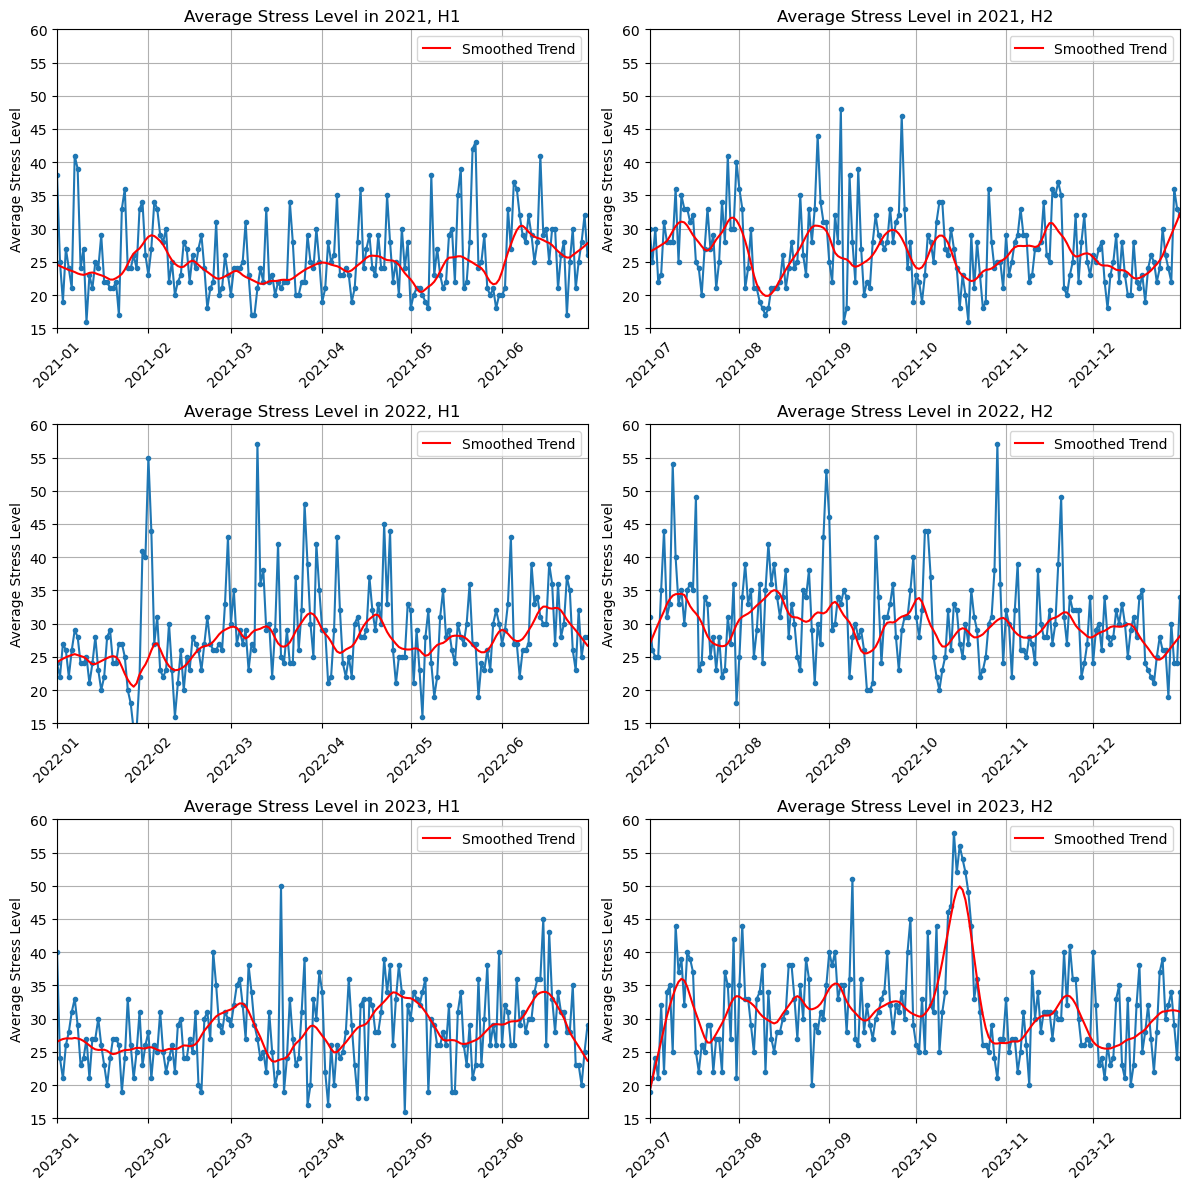

**Figure 2.** The first plot chosen for the article, was a plot for showing the cariability of average stress for the past 8 semesters, including my main (career) focus in these semeser. The purpose was an introduction to an overview of stress and teaching.

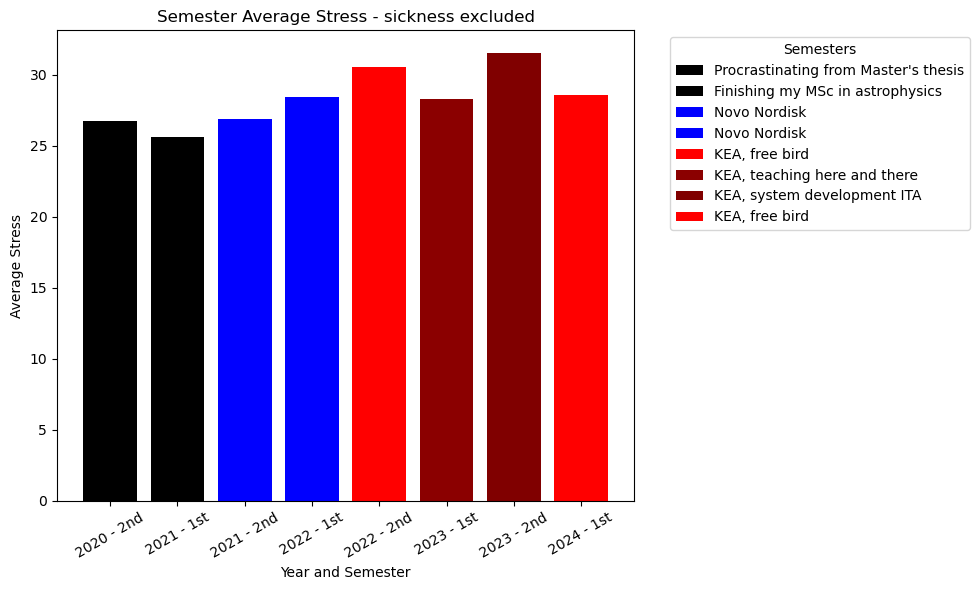

**Figure 3.** Figure 2 was followed by a overview of each semester for the weekdays, as I was grasping for patterns of teaching days. Intersting I found a pattern of highest stress on Saturdays for most of the semesters, except for the 2nd semester in 2023, where I might have been less kean on going out and socializing with alcohol. This peaked my interested in weekdays vs weekends comparison, and I invited the readers along on my explorative journey.

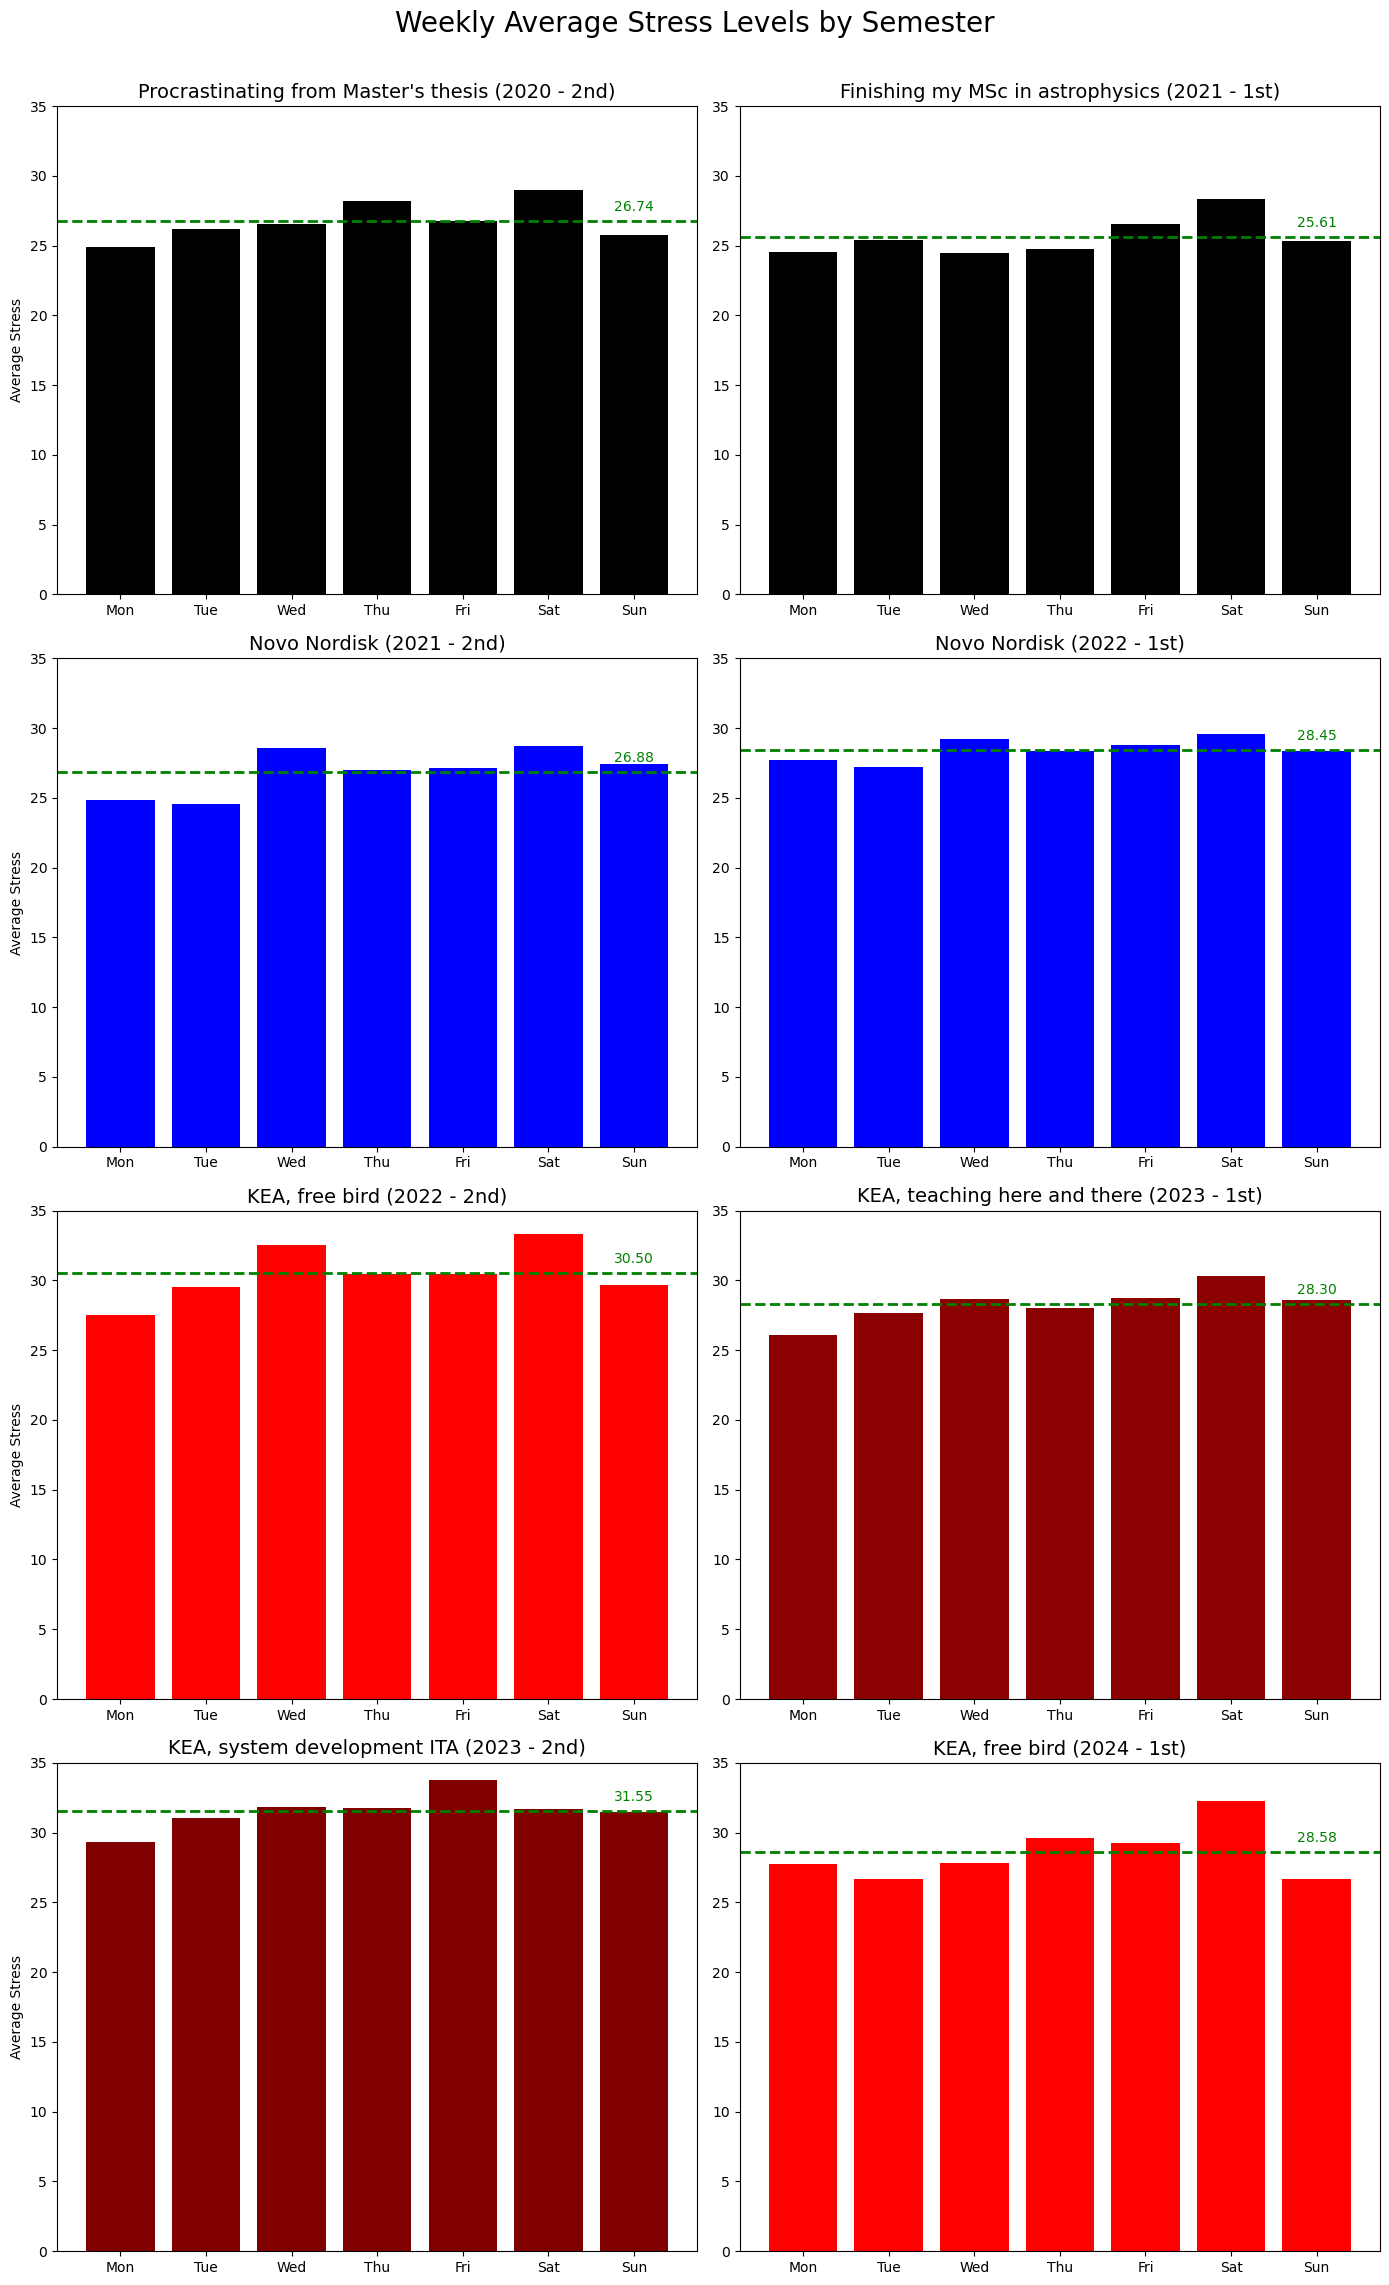

**Figure 4.** Boxplots showing a comparison of the average stress (left) and sleeping hours on weekdays vs weekends (right). T-test for stress levels: T-statistic: -2.799, P-value: 0.0053 and T-test for sleep levels: T-statistic: -2.972, P-value: 0.0031, show a statistical significance on the differences. 
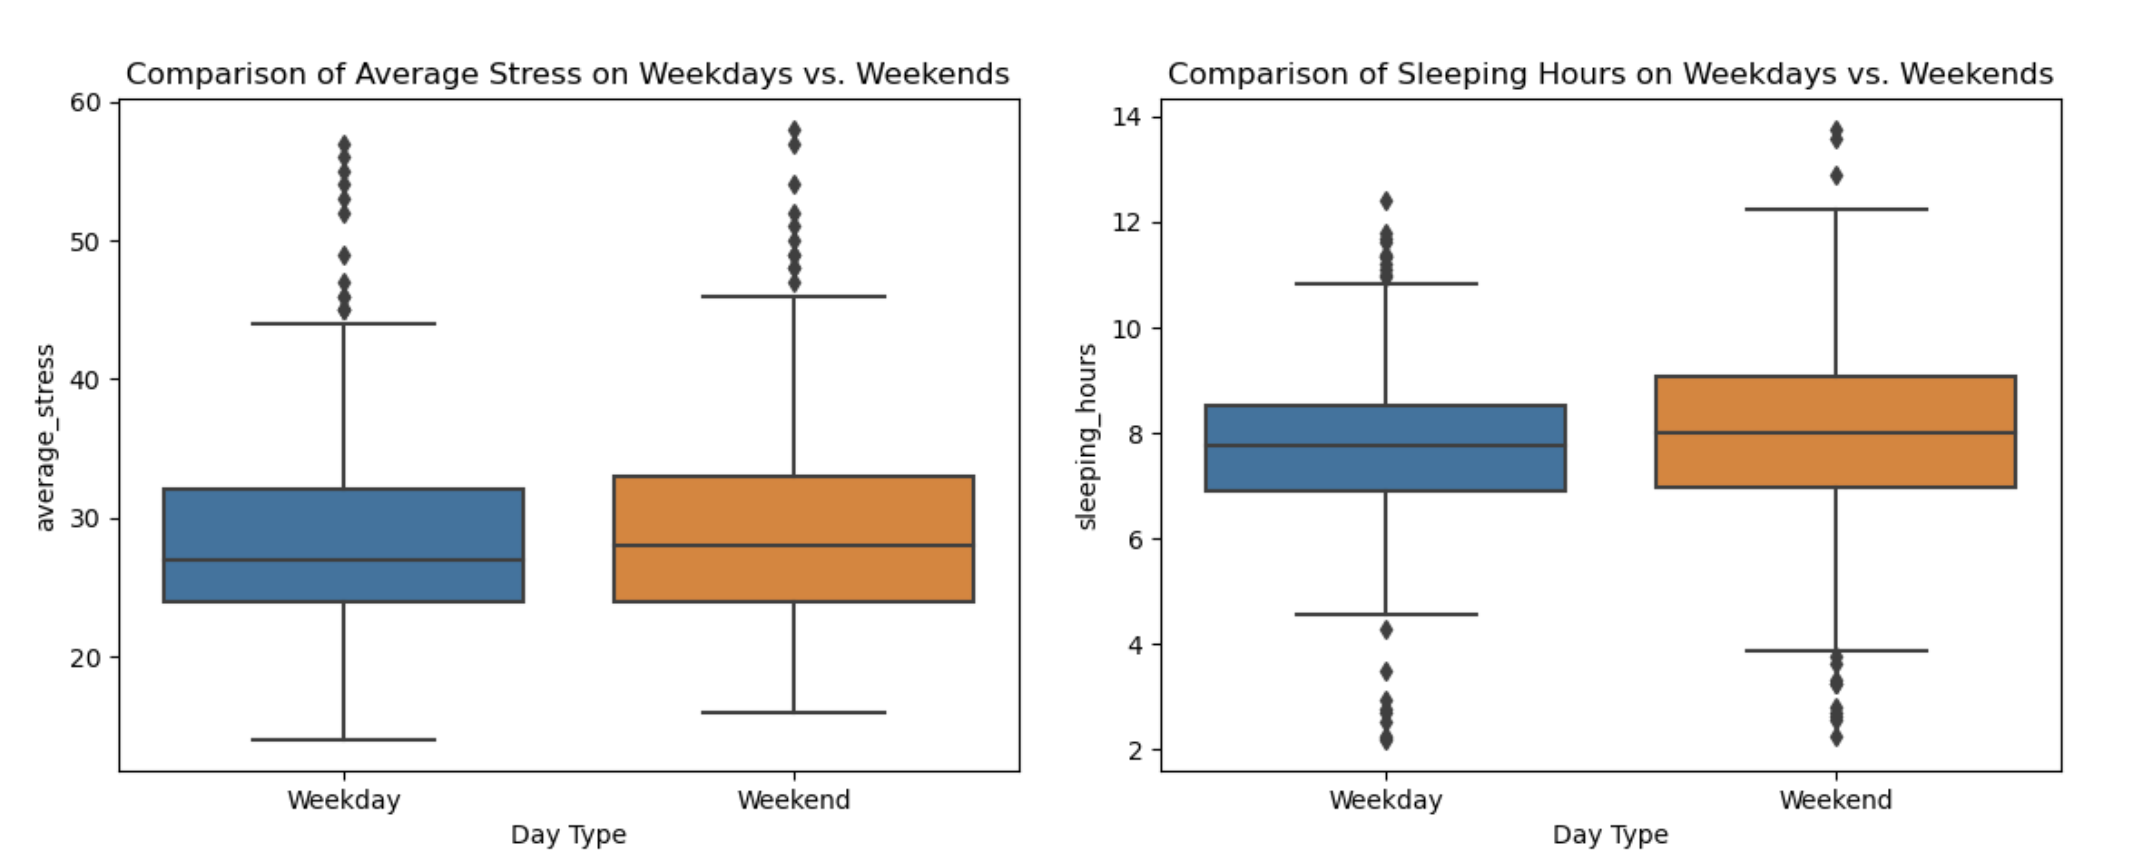


**Figure 5.** Moving on to other factors, I zoomed in on stress levels for 2nd semester of 2023, to show the 18 days of feverish sickness that stand out.

I did a T-test to check 1) how much higher is the stress level for this semester in general compared to the other semester and 2) the same, but excluding the sick days for a "healthy day only" comparison. The values showed that the stress-levels were significally higher, even when not including the sick days. 

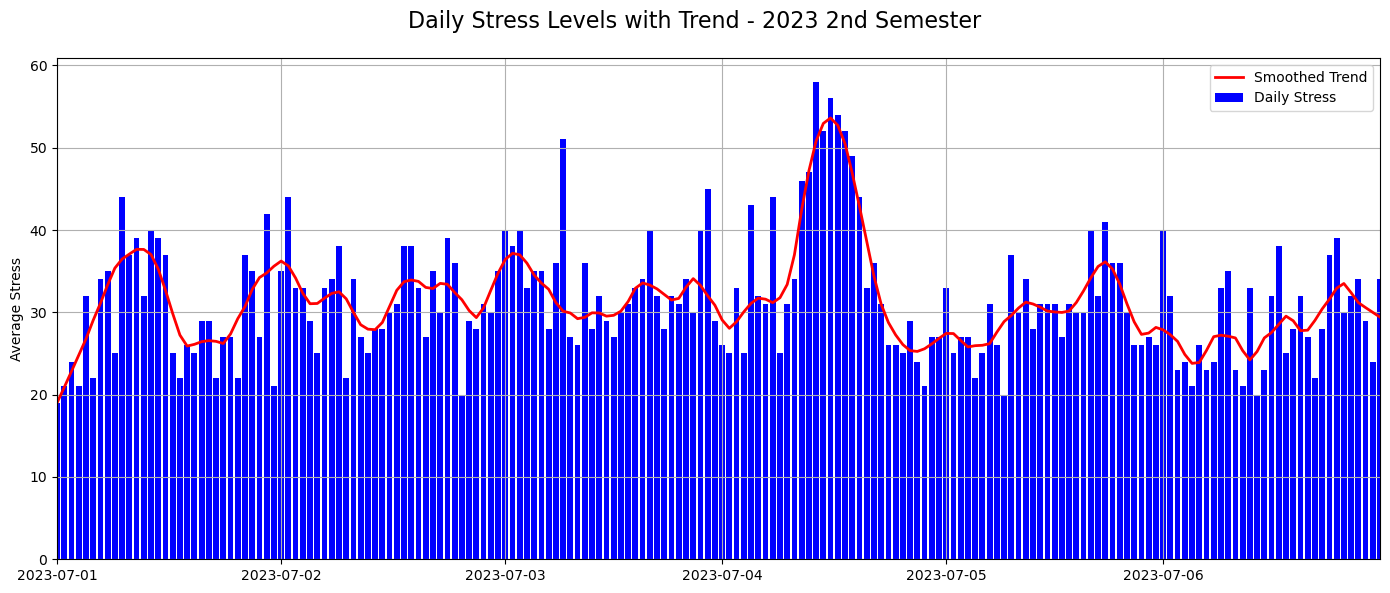

**Figure 6.** Speaking of other factors, I decided to finally ad the teaching days manually to my data, to spot if there would be significal difference in the stress levels on teaching days (mainly the lecturing and occational public speaking), it the analasys showed that there were. 

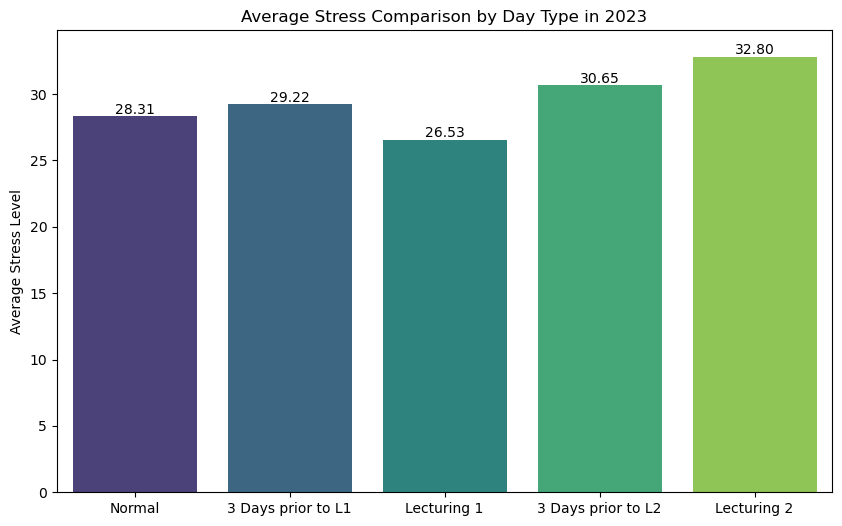

**Figure 7.** The result of the XGBoost algorithm and the SHAP analysis showed the influence of sleep components, resting heart rate, and running distance (Km) on average stress level. SHAP values quantify the impact of each feature (on the left) on the model's output (average stress). A positive SHAP value indicates that a feature pushes the model's prediction higher (more stress), while a negative value indicates a push towards a lower prediction (less stress).

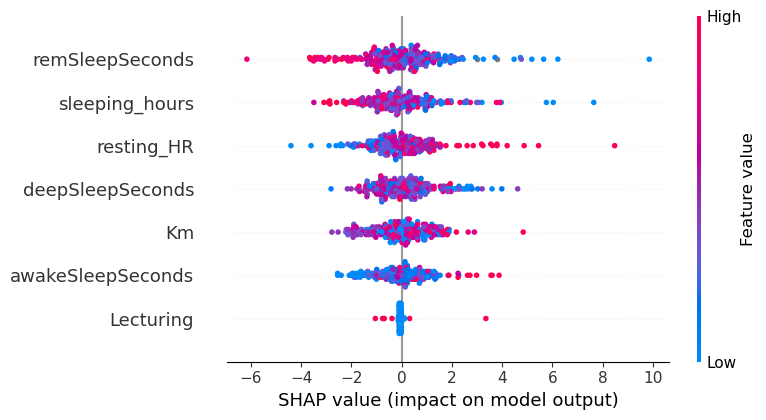

**Figure 8.** A scatter plot of the relation between daily resting heart rate and average stress for the day, colored by emotional categories. The insights we mainly got from here, were the outliers for the sick days (as seen in the subplot for 2023 H2 in October in Figure 1, where both stress levels and heart rate were highly elevated. At the same time, most of those days were filled an extreme fatigue feeling.

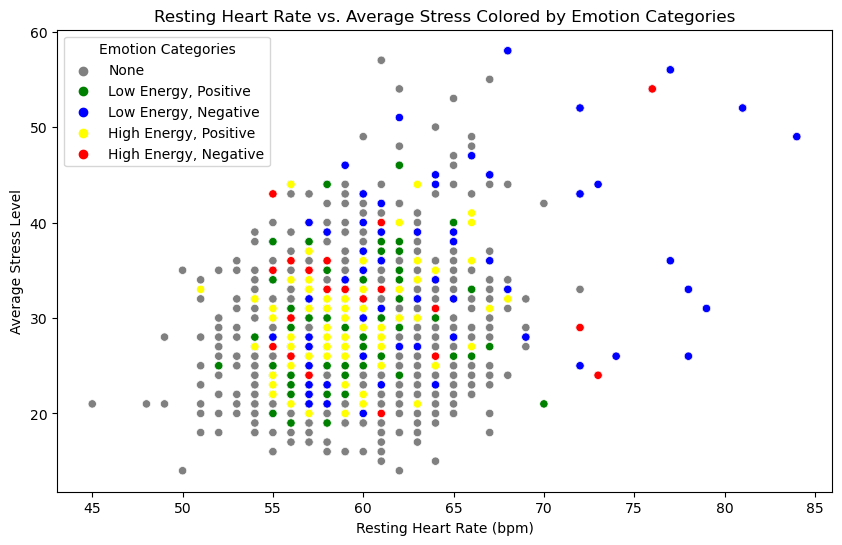




**Figure 10.** Impact of the 4 mood categories used in the HowWeFeel app: low energy, positive (such as chill, balanced, thoughtful), high energy positive (such as accomplished, excited, productive), high energy, negative (such as anxious, annoyed, worried), and low energy, negative (such as tired, lonely, sad). Although the data here was limited, it does suggest a pattern, where positive, low-energy (such as chill), and high-energy (such as excited) moods, tend to decrease the predicted stress levels (points with high impact to the left). The blue points to the right are cases of increased predicted stress but with a lower impact value.

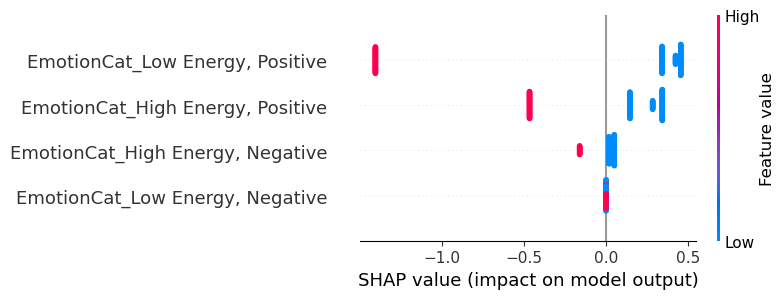

### Why are they right for the story you want to tell?
The story's aim is to communicate data to readers without any prior knowledge of data visualization. Our first visualization, a bar chart, was deliberately chosen to communicate the main points in an easy-to-understand way. The bar chart often has this quality, being intuitively easy to understand for an inexperienced reader. Later, we extended the story with different charts, such as a "box-and-whisker plot," "SHAP summary plot," and "scatter plots." Often, these require some explanation for the reader to understand the message. 

## Discussion. 
Think critically about your creation
* What went well?,
* What is still missing? What could be improved?, Why?


Measuring stress levels with a Garmin watch and exploring diverse metrics, can give insight into personal and environmental stress factors. However, stress is a complex thing; it can be short-term (which can be a good thing) or long-term (which can be damaging); it can be a subjective feeling, or it can be physically measurable. Short-term stress can strengthen the resilience of long-term stress, which isn't something we have taken into account here.

While we have looked at daily average stress levels, it would also be intersting to zoom in and look at more detailed fluctuations in stressors during a 24h day, together with specific target features, such as a break down of what the test subject is doing to elevate stress or to relax. 

For this purpose (and in general), it would also make sense to have more than one person to study. This would also make it more interesting for the broader audience.

To get a deeper insight into stressors, we could  take many other parameters into account. Some can be complex and hard to identify and quantify (affection, acknowledgements, smiles, positive thoughts, resilient mind etc), but others are readily available in unexplored garmin data, such as more of the activities, the body battery, intensity minutes, steps and more. 

As a personal interst, I got really curious about analysing my year long daily journal in a sentiment analysis, relating the foundings to other factors in life and decision making based on tracked (and maybe forgotten)  experience.

As it typically goes, I did get started later than expected, and my team mate responsible for this notebook decided to quit 

## Contributions. 
<!-- Who did what?
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".-->

**Magdalena (Lenka) Otap**
* Medium article and storyline
* In the end, most of the data analysis, and the rest of the final version of the explainer noterbook, as Claus left the group 😢 

**Claus Bové**
* Explainer Notebook and resting heart rate plot

## Make sure that you use references when they're needed and follow academic standards.


Oh well.